## Project structure

├── data\
│   ├── metadata.csv\
│   ├── SampleSubmission.csv\
│   ├── Test.csv\
│   ├── Train.csv\
│   └── VariablesDefinition.txt\
├── logs\
├── models\
├── src\
│   └── StarterNotebook.ipynb\
└── submissions


## Libs

In [39]:
import os
import ast
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sn
from tqdm.std import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

import logging
logging.basicConfig(level='INFO')


logging.info(msg=f"Using tensorflow version : {tf.__version__}")

In [40]:
import warnings
warnings.filterwarnings(action="ignore")

In [41]:
np.random.seed(42)

## Config & Helpers funcs

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
class Config:
    data_dir = '/content/drive/MyDrive/ambassador-skill-up-hackathon/'
    working_dir = 'src/'#'../src/'
    models_dir = 'models/'#'../models/'
    submissions_dir = 'submissions/'#'../submissions'


def create_target(df:pd.DataFrame, window:int=2):
    
    """
    Compute a target column : this column will be the answer to the following question
    (Did the company receive a payment after the term date + (window * term) days) and (total amount paid so far grater that 60% of contract value) ? 
                                        
                        ********************************************************************
                                                    DISCLAIMER
                        ********************************************************************
                                        
        This target may not be accurate...anyway, you should create your own target to predict contract status 
                    since your end model is not evaluated on this task (predicting contract status)

                        ********************************************************************
                                                    DISCLAIMER
                        ********************************************************************

        Parameters
        ----------
            df : pandas dataframe - like
                dataframe to add targets to. (should contain the payments history)
                
            window : int
                number of repeated term(s) to look at
                
        Returns
        -------
        
            df : pandas dataframe - like
                dataframe with a 'Target' column
    """
    try:
        df = df.copy()
        
        df["ExpectedTermDate"] = pd.to_datetime(df["ExpectedTermDate"]) + pd.to_timedelta(pd.np.ceil(df.Term*window), unit="D")
        df["LastPaymentDate"] = pd.to_datetime(df["LastPaymentDate"]).dt.tz_localize(None)
        
        targets = []
        
        for r in df.iterrows():
            r = r[1]
            target = ((100 * sum(ast.literal_eval(r.PaymentsHistory) + r[-6:].values.tolist()) // r.TotalContractValue)>=60.) and (r.LastPaymentDate < r.ExpectedTermDate)
            targets.append(float(target))
            
        df["Target"] = targets
        
        del targets
    
        return df
    
    except Exception as ex:
        logging.error(msg=f'{ex}')
        
        return None


def get_viz(df:pd.DataFrame):
    """
        Make a simple Visialization of some variables
        
    Parameters
    ----------
        df : pandas dataframe - like
            metadata dataframe
            
    Returns
    -------
        fig : Matplotlib Figure - like
    """
    
    fig, axes = pyplot.subplots(figsize=(25, 15), nrows=2, ncols=3)

    # class distrib
    axes[0, 0].set_title(label='Good/Bad payer countplot')

    sn.countplot(x=df.Target,ax=axes[0, 0])

    vals = df.Target.value_counts().values.tolist()
    vals.reverse()
    for a,p in zip(vals, axes[0, 0].patches):
        axes[0, 0].annotate(
            xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
            text=a,
            ha='center', 
            va='center', 
            fontsize=13, 
            color='black', 
            xytext=(1, 5),
            textcoords='offset points'
        )

    bad_patch = mpatches.Patch(color='#1f77b4', label='Bad')
    good_patch = mpatches.Patch(color='orange', label='Good')

    axes[0, 0].legend(handles=[bad_patch, good_patch])

    # regions distrib
    axes[0, 1].set_title(label='Region distribution')
    sn.countplot(x=df.Region, ax=axes[0, 1])
    axes[0, 1].set_xticklabels(labels=axes[0, 1].get_xticklabels(), rotation=30)

    # ages distrib
    axes[0, 2].set_title(label='Ages distribution')
    sn.histplot(x=df.Age, ax=axes[0, 2])

    # Gender distrib
    axes[1, 0].set_title(label='Gender distribution')
    sn.countplot(x=df.MainApplicantGender, ax=axes[1, 0])

    #  Town distrib
    axes[1, 1].set_title(label='Town distribution')
    sn.countplot(x=df.Town, ax=axes[1, 1])
    axes[1, 1].set_xticklabels(labels=axes[1, 1].get_xticklabels(), rotation=90)

    # Customer ocupation distrib
    axes[1, 2].set_title(label='Occupation distribution')
    sn.countplot(x=df.Occupation, ax=axes[1, 2])
    axes[1, 2].set_xticklabels(labels=axes[1, 2].get_xticklabels(), rotation=90)

    pyplot.tight_layout()
    pyplot.show()
    
    return fig



def preprocess_data(df:pd.DataFrame, skip_cols:list=None)->pd.DataFrame:
    """
        Preprocessing pipeline for AFC hackathon datasets
        
        Parameters
        ----------
            df : Pandas dataframe
                Dataframe to be preprocessed.
                
            skip_cols : list
                list of columns to skip during preprocessing
                
        Returns
        -------
            df : Pandas dataframe
                Preprocessed dataframe.
        
        Examples
        --------
        >>> dataset = pd.read_csv(filepath_or_buffer='<path_to_data.csv>') 
        >>> new_df = preprocess_data(df=dataset) 
        
    """
    
    df = df.copy(deep=True)
    cols = [col for col in df.columns[1:] if col not in skip_cols]
    cat_cols = [col for col in cols if df[col].dtype == 'O' and 'Date' not in col]
    date_cols = [col for col in cols if 'Date' in col]
    
    # convert cat col to category type
    # print("Categorical cols", cat_cols)
    for col in tqdm(cat_cols, desc='Processing categorical columns \t'):
        df[col] = df[col].astype('category')
        
    # print("Date cols", date_cols)
    # convert date col to datetime type
    for col in tqdm(date_cols, desc='Processing datetime columns \t'):
        df[col] = pd.to_datetime(df[col]).dt.tz_localize(None)
    
    # fill missing values
    df.UpsellDate.fillna(value='None', inplace=True)
    df.Region.fillna(value=df.Region.mode()[0], inplace=True)
    df.Age.fillna(value=round(df.Age.mean()), inplace=True)
    
    for col in cat_cols:            
        try:
            df[col] = df[col].cat.codes
        except Exception as ex:
            logging.error(msg=f"Column issue ({col}) : {ex}")

        
    return df


def extract_features(df:pd.DataFrame)->pd.DataFrame:
    df = df.copy()
    df['RegisteredInLeapYear'] = df.RegistrationDate.dt.is_leap_year.astype('float')
    df['RegisteredAtMonthStart'] = df.RegistrationDate.dt.is_month_start.astype('float')
    df['RegisteredAtMonthEnd'] = df.RegistrationDate.dt.is_month_end.astype('float')
    df['LastPaymentMonth'] = df.LastPaymentDate.dt.month
    df['FirstPaymentMonth'] = df.FirstPaymentDate.dt.month
    
    return df.drop(columns=["TransactionDates", "PaymentsHistory", "m1", "m2", "m3", "m4", "m5", "m6"], inplace=False)


def pad_history(df:pd.DataFrame, max_len:int=41):
    
    df = df.copy()
    
    padded_payments = []
    
    for r in df.copy().iterrows():
        r = r[1]
        
        if len(ast.literal_eval(r.PaymentsHistory)) > max_len:
            padded_payments.append(ast.literal_eval(r.PaymentsHistory)[:max_len])
            
        else:
            padding_len = abs(max_len - len(ast.literal_eval(r.PaymentsHistory)))
            padded_payments.append(ast.literal_eval(r.PaymentsHistory) + padding_len*[0.])
            
    
    df["PaymentsHistory"] = padded_payments
    
    del padded_payments
    
    return df, max_len

# Dataset
---
1. Load files
2. Exploratory Data Analysis (EDA)
3. Preprocess data
4. Extract features
4. Train/Test split

In [43]:
train = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "Train.csv"))
metadata = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "metadata.csv"))
test = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "Test.csv"))
ss = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "SampleSubmission.csv"))

### EDA

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28007 entries, 0 to 28006
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                28007 non-null  object 
 1   TransactionDates  28007 non-null  object 
 2   PaymentsHistory   28007 non-null  object 
 3   m1                28007 non-null  float64
 4   m2                28007 non-null  float64
 5   m3                28007 non-null  float64
 6   m4                28007 non-null  float64
 7   m5                28007 non-null  float64
 8   m6                28007 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.9+ MB


In [45]:
train.describe(datetime_is_numeric=True).transpose()

,count,mean,std,min,25%,50%,75%,max
m1,28007.0,815.411683,686.130805,1.0,275.0,820.0,1200.0,33890.0
m2,28007.0,807.101617,839.772177,1.0,250.0,800.0,1200.0,94044.0
m3,28007.0,797.641161,696.809281,1.0,220.0,790.0,1200.0,32005.0
m4,28007.0,815.011033,715.582046,1.0,230.0,815.0,1200.0,33403.0
m5,28007.0,827.719463,796.379837,1.0,220.0,840.0,1205.0,64106.0
m6,28007.0,692.115150,1416.301221,1.0,130.0,480.0,915.0,96814.0


In [46]:
train.head(n=2)

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0


In [47]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37343 entries, 0 to 37342
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   37343 non-null  object 
 1   RegistrationDate     37343 non-null  object 
 2   Deposit              37343 non-null  int64  
 3   UpsellDate           973 non-null    object 
 4   AccessoryRate        37343 non-null  float64
 5   PaymentMethod        37343 non-null  object 
 6   rateTypeEntity       37343 non-null  object 
 7   RatePerUnit          37343 non-null  int64  
 8   DaysOnDeposit        37343 non-null  int64  
 9   MainApplicantGender  37343 non-null  object 
 10  Age                  30404 non-null  float64
 11  Region               35409 non-null  object 
 12  Town                 37343 non-null  object 
 13  Occupation           37343 non-null  object 
 14  SupplierName         37343 non-null  object 
 15  Term                 37343 non-null 

In [48]:
metadata.describe(datetime_is_numeric=True).transpose()

,count,mean,std,min,25%,50%,75%,max
Deposit,37343.0,2348.631685,417.814614,0.0,2000.0,2000.0,2500.0,8000.0
AccessoryRate,37343.0,1.136090,7.791789,0.0,0.0,0.0,0.0,240.0
RatePerUnit,37343.0,49.923868,57.500215,35.0,40.0,40.0,55.0,4000.0
DaysOnDeposit,37343.0,4.600835,3.429060,0.0,3.0,3.0,7.0,60.0
Age,30404.0,38.855677,12.300827,19.0,29.0,36.0,46.0,120.0
Term,37343.0,412.427657,121.602544,10.0,364.0,364.0,547.0,626.0
TotalContractValue,37343.0,22953.005142,10149.863172,10800.0,16560.0,16560.0,33080.0,64484.0


In [49]:
metadata.head(n=2)

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
0,ID_K00S4N4,2015-12-10 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35,2016-10-23 04:52:30
1,ID_6L67PAA,2015-12-09 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03,2020-05-24 15:32:18


In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9336 entries, 0 to 9335
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                9336 non-null   object
 1   TransactionDates  9336 non-null   object
 2   PaymentsHistory   9336 non-null   object
dtypes: object(3)
memory usage: 218.9+ KB


In [51]:
test.describe(datetime_is_numeric=True).transpose()

,count,unique,top,freq
ID,9336,9336,ID_6L67PAA,1
TransactionDates,9336,2938,"['01-2020', '02-2020', '03-2020', '04-2020', '...",333
PaymentsHistory,9336,9290,"[3500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....",15


In [52]:
test.head(n=2)

,ID,TransactionDates,PaymentsHistory
0,ID_6L67PAA,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4000.0, 1050.0, 1050.0, 1050.0, 1050.0, 400.0]"
1,ID_VJ80SX2,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, ..."


In [53]:
print("---------------- Missing values Report ----------------")
print(train.isna().sum())

---------------- Missing values Report ----------------
ID                  0
TransactionDates    0
PaymentsHistory     0
m1                  0
m2                  0
m3                  0
m4                  0
m5                  0
m6                  0
dtype: int64


In [54]:
print("---------------- Missing values Report ----------------")
print(test.isna().sum())

---------------- Missing values Report ----------------
ID                  0
TransactionDates    0
PaymentsHistory     0
dtype: int64


In [55]:
print("---------------- Missing values Report ----------------")
print(metadata.isna().sum())

---------------- Missing values Report ----------------
ID                         0
RegistrationDate           0
Deposit                    0
UpsellDate             36370
AccessoryRate              0
PaymentMethod              0
rateTypeEntity             0
RatePerUnit                0
DaysOnDeposit              0
MainApplicantGender        0
Age                     6939
Region                  1934
Town                       0
Occupation                 0
SupplierName               0
Term                       0
TotalContractValue         0
ExpectedTermDate           0
FirstPaymentDate           0
LastPaymentDate            0
dtype: int64


In [56]:
merged = pd.merge(left=metadata, right=pd.concat(objs=[train, test]).fillna(value=0.), on="ID")

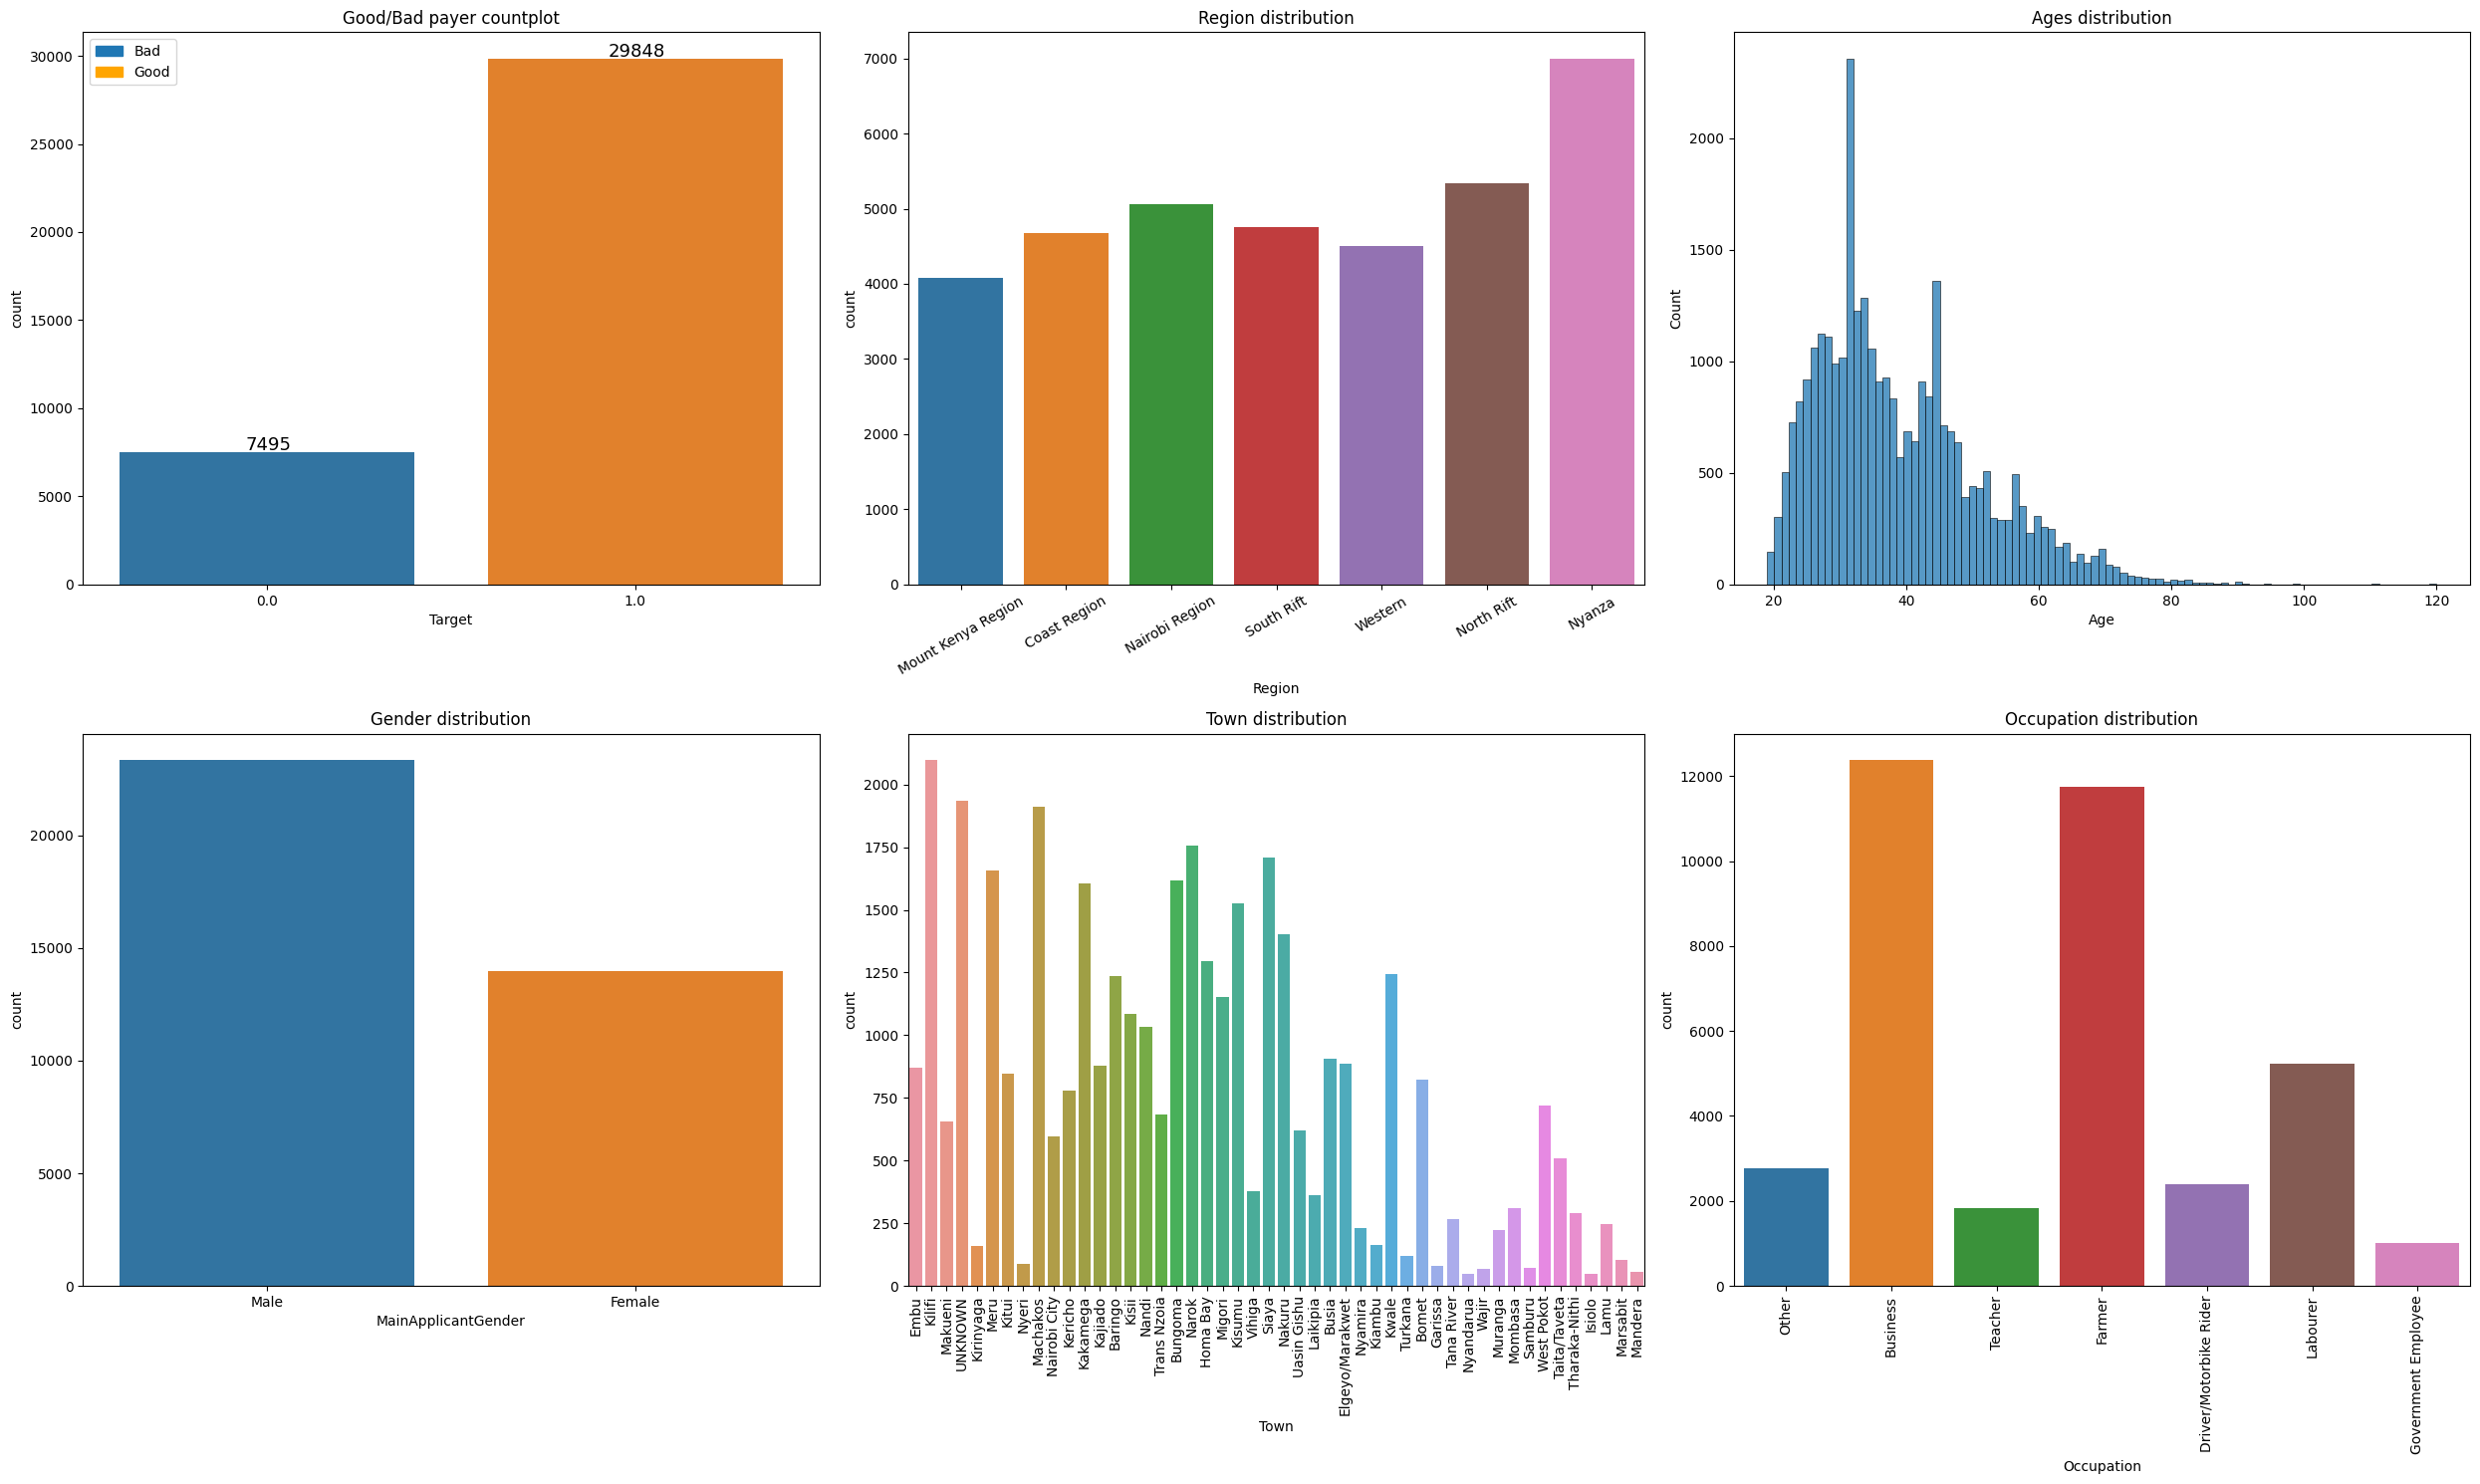

In [57]:
merged = create_target(df=merged, window=4)

### some visualization
fig = get_viz(df=merged)

### Preprocessing

In [58]:
merged_ = preprocess_data(df=merged, skip_cols=["PaymentsHistory", "TransactionDates"])

Processing datetime columns 	: 100%|██████████| 5/5 [00:00<00:00, 23.48it/s]


In [59]:
merged_.isna().sum()

ID                     0
RegistrationDate       0
Deposit                0
UpsellDate             0
AccessoryRate          0
PaymentMethod          0
rateTypeEntity         0
RatePerUnit            0
DaysOnDeposit          0
MainApplicantGender    0
Age                    0
Region                 0
Town                   0
Occupation             0
SupplierName           0
Term                   0
TotalContractValue     0
ExpectedTermDate       0
FirstPaymentDate       0
LastPaymentDate        0
TransactionDates       0
PaymentsHistory        0
m1                     0
m2                     0
m3                     0
m4                     0
m5                     0
m6                     0
Target                 0
dtype: int64

### Features extraction

In [60]:
merged_ = extract_features(df=merged_)
merged_.head(n=2)

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,...,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate,Target,RegisteredInLeapYear,RegisteredAtMonthStart,RegisteredAtMonthEnd,LastPaymentMonth,FirstPaymentMonth
0,ID_K00S4N4,2015-12-10,2000,None,0.0,0,0,35,7,1,...,14740.0,2020-12-03,2015-12-10 09:52:35,2016-10-23 04:52:30,1.0,0.0,0.0,0.0,10,12
1,ID_6L67PAA,2015-12-09,2000,None,0.0,0,0,35,7,1,...,14740.0,2020-12-02,2015-12-09 13:14:03,2020-05-24 15:32:18,0.0,0.0,0.0,0.0,5,12


In [61]:
selected_features = [c for c in merged_.columns[1:] if "Date" not in c]
xtrain_loan = merged_[selected_features]
ytrain_loan = merged_.Target
## Split
xtrain_loan, xval_loan, ytrain_loan, yval_loan = train_test_split(
    xtrain_loan, 
    ytrain_loan, 
    test_size=.15, 
    random_state=42, 
    shuffle=True
)
scaler = StandardScaler()
##Fit scaler
scaler.fit(X=xtrain_loan.values)

## Scale data
xtrain_loan = scaler.transform(X=xtrain_loan.values)
xval_loan = scaler.transform(X=xval_loan.values)

print(f"> Training inputs shape : {xtrain_loan.shape}, Training targets shape : {ytrain_loan.shape}")
print(f"> Validation inputs shape : {xval_loan.shape}, Training targets shape : {yval_loan.shape}")

> Training inputs shape : (31741, 20), Training targets shape : (31741,)
> Validation inputs shape : (5602, 20), Training targets shape : (5602,)


### Train/Val split

In [62]:
train, max_len = pad_history(df=train, max_len=41)

xtrain = train.PaymentsHistory.values
ytrain = train[train.columns[-6:]].values

xs = np.array(xtrain.tolist()).reshape((xtrain.shape[0], 1, max_len))
ys = np.array(ytrain.tolist()).reshape((ytrain.shape[0], 1, 6))

train_ds = tf.data.Dataset.from_tensor_slices((xs, ys))

In [63]:
for sample in train_ds:
    print(sample)
    break

(<tf.Tensor: shape=(1, 41), dtype=float64, numpy=
array([[3600.,  750.,  350.,   65.,   95.,  135.,   85.,   55.,  345.,
         155.,   55.,  630.,  585.,  185.,  440.,  483.,  660.,  515.,
         292.,  505.,  210.,  120.,  260.,  610.,  230.,  390.,  660.,
        1200., 1320.,  280.,  770.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]])>, <tf.Tensor: shape=(1, 6), dtype=float64, numpy=array([[880., 930., 495., 715., 220., 385.]])>)


## Modelling

In [64]:
def build_model():
    
    payments_inp = keras.Input(shape=(41), name="payments_inputs")
    status_inp = keras.Input(shape=(xtrain_loan.shape[1]), name="status_inputs")
    
    x1 = keras.layers.Dense(35, activation="sigmoid", name="x1")(status_inp)
    out1 = keras.layers.Dense(1, name="loan_status_out")(x1)
    
    
    x2 = keras.layers.Dense(20, activation="sigmoid", name="x2")(payments_inp)
    x2_out = keras.layers.Dense(30, activation="sigmoid", name="payment_out")(x2)
    
    concat = keras.layers.Concatenate(name="concat_layer")([out1, x2_out])
    out2 = keras.layers.Dense(6, name="out")(concat)
    
    # Model
    model = keras.Model(inputs=[payments_inp, status_inp], outputs=[out1, out2])
    
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    wgt = {"out1":.7, "out2":.3}
    
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
        loss_weights=wgt
    )

    model.summary()
    
    return model


def build_simple_model():
    
    payments_inp = keras.Input(shape=(41), name="payments_inputs")

    x = keras.layers.Dense(35, activation="relu", name="x2")(payments_inp)
    x_out = keras.layers.Dense(50, activation="relu", name="payment_out")(x)
    
    out = keras.layers.Dense(6, name="out")(x)
    
    # Model
    model = keras.Model(inputs=[payments_inp], outputs=[out])
    
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
    )

    model.summary()
    
    return model


def build_status_model():
    
    status_inp = keras.Input(shape=(xtrain_loan.shape[1]), name="status_inputs")

    x = keras.layers.Dense(30, activation="relu", name="x2")(status_inp)
    x_out = keras.layers.Dense(45, activation="relu", name="statut_out")(x)
    
    out = keras.layers.Dense(6, name="out")(x)
    
    # Model
    model = keras.Model(inputs=[status_inp], outputs=[out])
    
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
    )

    model.summary()
    
    return model

In [65]:
model = build_simple_model()#build_model()#

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 payments_inputs (InputLayer  [(None, 41)]             0         
 )                                                               
                                                                 
 x2 (Dense)                  (None, 35)                1470      
                                                                 
 out (Dense)                 (None, 6)                 216       
                                                                 
Total params: 1,686
Trainable params: 1,686
Non-trainable params: 0
_________________________________________________________________


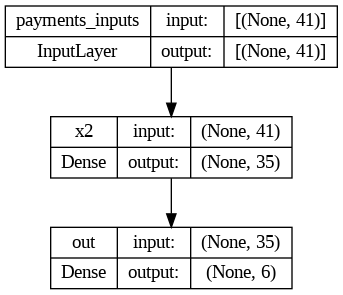

In [66]:
tf.keras.utils.plot_model(
        model,
        to_file="../model.png", 
        show_shapes=True
    )

## Learning phase

In [67]:
model.fit(train_ds, batch_size=16, epochs=15)

Epoch 1/15
28007/28007 [==============================] - 43s 2ms/step - loss: 733176.2500
Epoch 2/15
28007/28007 [==============================] - 44s 2ms/step - loss: 667714.9375
Epoch 3/15
28007/28007 [==============================] - 41s 1ms/step - loss: 655794.0000
Epoch 4/15
28007/28007 [==============================] - 42s 1ms/step - loss: 649085.5625
Epoch 5/15
28007/28007 [==============================] - 42s 1ms/step - loss: 644634.7500
Epoch 6/15
28007/28007 [==============================] - 41s 1ms/step - loss: 641412.4375
Epoch 7/15
28007/28007 [==============================] - 42s 1ms/step - loss: 638885.5000
Epoch 8/15
28007/28007 [==============================] - 42s 1ms/step - loss: 636665.3125
Epoch 9/15
28007/28007 [==============================] - 42s 1ms/step - loss: 634926.8750
Epoch 10/15
28007/28007 [==============================] - 42s 1ms/step - loss: 633409.2500
Epoch 11/15
28007/28007 [==============================] - 43s 2ms/step - loss: 632133.00

## Eval/Inference time

In [68]:
def predict(test:pd.DataFrame):
    test, max_len = pad_history(df=test, max_len=41)

    xtest = test.PaymentsHistory.values
    xtest = np.array(xtest.tolist()).reshape((xtest.shape[0], 1, max_len))
    
    test_ds = tf.data.Dataset.from_tensor_slices(xtest)
    preds = model.predict(test_ds)
    
    assert preds.shape[0] == test.shape[0], f"Shape mismatch, {preds.shape[0]} predictions found while test set has {test.shape[0]} rows"
    
    return preds.flatten()

In [69]:
preds = predict(test=test)

9336/9336 [==============================] - 11s 1ms/step


In [70]:
preds.shape, ss.shape

((56016,), (56016, 2))

## Create submission

In [ ]:
ss.head(n=12)

,ID,Target
0,ID_6L67PAA x m1,0.0
1,ID_6L67PAA x m2,0.0
2,ID_6L67PAA x m3,0.0
3,ID_6L67PAA x m4,0.0
4,ID_6L67PAA x m5,0.0
5,ID_6L67PAA x m6,0.0
6,ID_VJ80SX2 x m1,0.0
7,ID_VJ80SX2 x m2,0.0
8,ID_VJ80SX2 x m3,0.0
9,ID_VJ80SX2 x m4,0.0


In [71]:
ss["Target"] = preds

In [72]:
ss.head(n=12)

,ID,Target
0,ID_6L67PAA x m1,980.954163
1,ID_6L67PAA x m2,964.672729
2,ID_6L67PAA x m3,914.256531
3,ID_6L67PAA x m4,928.381653
4,ID_6L67PAA x m5,924.758789
5,ID_6L67PAA x m6,753.508667
6,ID_VJ80SX2 x m1,962.031250
7,ID_VJ80SX2 x m2,939.321106
8,ID_VJ80SX2 x m3,897.650818
9,ID_VJ80SX2 x m4,940.213501


In [73]:
ss.to_csv('Ambassador_zindi_sub5.csv', index=False) 

In [ ]:
#ss.to_csv('Ambassador_zindi_sub3.csv', index=False) 

### some insights

1. !!! You must then build a machine learning model that returns the expected future payments for `n` months ahead !!! (Make sure one will be able to predict for more steps with your model and `set n=6 for this competition`)⚠️

2. Building a loan status predictor is highly recommended (likelihood of being a good/bad payer)✅

3. gradient boosting? random forest? reccurent net? even use an ensemble of many models. be creative 💡!

4. Cross validation ? why not 🤷🏾‍♂️

5. You can even try a Seq2Seq model : [resource](https://awaywithideas.com/keras-implementation-of-a-sequence-to-sequence-model-for-time-series-prediction-using-an-encoder-decoder-architecture/)